<a href="https://colab.research.google.com/github/federicobrancasi/Test-Time-Adaptation-for-Image-Classification/blob/main/Test_Time_Adaptation_for_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test-Time Adaptation for Image Classification (Deep Learning Project)


## Download Datasets

In [3]:
# download datasets from a shared folder in google drive
!gdown 1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1 # id for imagenet-a
!gdown 1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd # id for imagenet-v2

# unzip them!
!tar -xf imagenet-a.tar
!tar -xf imagenetv2-matched-frequency.tar.gz

!ls

Downloading...
From (original): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1
From (redirected): https://drive.google.com/uc?id=1-m3lAmp63chP_9kFZjAd5iNTCsck6yA1&confirm=t&uuid=d0c817de-0618-4a4e-8f56-84de7d7d54e1
To: /content/imagenet-a.tar
100% 688M/688M [00:04<00:00, 170MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd
From (redirected): https://drive.google.com/uc?id=1wbmp6PsLiECc4lrKdut1bB2avTKcFPhd&confirm=t&uuid=47cd9f55-cb51-4bfd-a603-070d0214047b
To: /content/imagenetv2-matched-frequency.tar.gz
100% 1.26G/1.26G [00:05<00:00, 219MB/s]
imagenet-a	imagenetv2-matched-frequency-format-val  sample_data
imagenet-a.tar	imagenetv2-matched-frequency.tar.gz


## Import Needed Libraries

In [4]:
# import libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import skimage
import torch
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Create Dataloader

In [30]:
# dataloader
"""
Input arguments:
  batch_size: mini batch size used during training
  img_root: path to the dataset parent folder.
            The folder just above the sub-folders or class folders
"""

def get_data(batch_size, img_root):
  # prepare data transformations for the train loader
  transform = list()
  transform.append(T.Resize((224, 224)))                      # resize each PIL image to 256 x 256
  # transform.append(T.RandomCrop((224, 224)))                  # randomly crop a 224 x 224 patch
  transform.append(T.ToTensor())                              # convert Numpy to Pytorch Tensor
  # transform.append(T.Normalize(mean=[0.485, 0.456, 0.406],
  #                              std=[0.229, 0.224, 0.225]))    # normalize with ImageNet mean
  transform = T.Compose(transform)                            # compose the above transformations into one

  # load data
  dataset = torchvision.datasets.ImageFolder(root=img_root, transform=transform)

  # create train and test splits (80/20)
  num_samples = len(dataset)
  training_samples = int(num_samples * 0.8 + 1)
  test_samples = num_samples - training_samples

  training_data, test_data = torch.utils.data.random_split(dataset,
                                                           [training_samples, test_samples])

  # initialize dataloaders
  train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

  return train_loader, test_loader

In [31]:
train_loader_imageneta, test_loader_imageneta = get_data(batch_size=128, img_root='/content/imagenet-a')
train_loader_imagenetv2, test_loader_imagenetv2 = get_data(batch_size=128, img_root='/content/imagenetv2-matched-frequency-format-val')

In [7]:
print("imagenet-a dataloader: ")
for X, y in test_loader_imageneta:
    print(f"Shape of Feature Batch X [N, C, H, W]: {X.shape}")
    print(f"Shape of Labels Batch y: {y.shape} {y.dtype}")
    break

print("\nimagenet-v2 dataloader: ")
for X, y in test_loader_imagenetv2:
    print(f"Shape of Feature Batch X [N, C, H, W]: {X.shape}")
    print(f"Shape of Labels Batch y: {y.shape} {y.dtype}")
    break

imagenet-a dataloader: 
Shape of Feature Batch X [N, C, H, W]: torch.Size([128, 3, 224, 224])
Shape of Labels Batch y: torch.Size([128]) torch.int64

imagenet-v2 dataloader: 
Shape of Feature Batch X [N, C, H, W]: torch.Size([128, 3, 224, 224])
Shape of Labels Batch y: torch.Size([128]) torch.int64


## Check Device

In [8]:
# get cuda device
if torch.cuda.is_available():
  device = "cuda"

print(f"Using {device} device")

Using cuda device


## Show some images from both Datasets

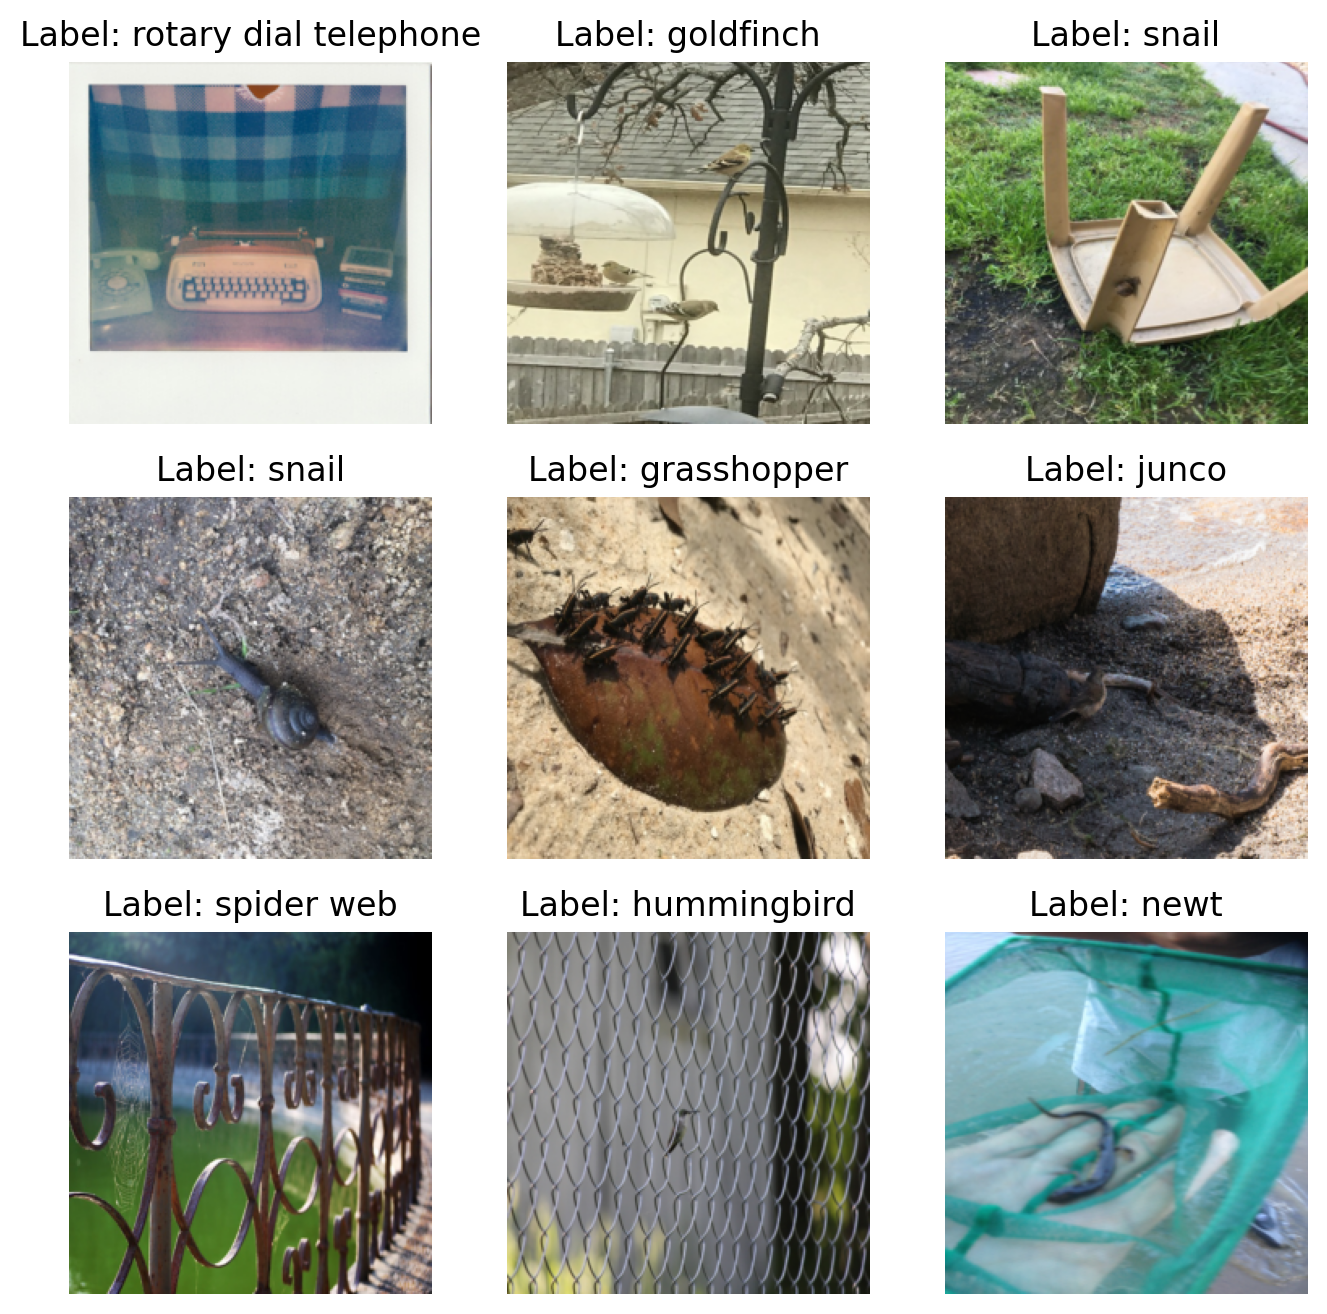

In [34]:
# show some imagenet-a images 😁

# label map for imagenet-a
label_map = {
    0: "stingray", 1: "goldfinch", 2: "junco", 3: "American robin", 4: "jay", 5: "bald eagle", 6: "vulture", 7: "newt", 8: "American bullfrog", 9: "box turtle", 10: "green iguana",
    11: "agama", 12: "chameleon", 13: "American alligator", 14: "garter snake", 15: "harvestman", 16: "scorpion", 17: "tarantula", 18: "centipede", 19: "sulphur-crested cockatoo",
    20: "lorikeet", 21: "hummingbird", 22: "toucan", 23: "duck", 24: "goose", 25: "koala", 26: "jellyfish", 27: "sea anemone", 28: "flatworm", 29: "snail", 30: "crayfish",
    31: "hermit crab", 32: "flamingo", 33: "great egret", 34: "oystercatcher", 35: "pelican", 36: "sea lion", 37: "Chihuahua", 38: "Golden Retriever", 39: "Rottweiler",
    40: "German Shepherd Dog", 41: "pug", 42: "red fox", 43: "Persian cat", 44: "lynx", 45: "lion", 46: "American black bear", 47: "mongoose", 48: "ladybug", 49: "rhinoceros beetle",
    50: "weevil", 51: "fly", 52: "bee", 53: "ant", 54: "grasshopper", 55: "stick insect", 56: "cockroach", 57: "mantis", 58: "leafhopper", 59: "dragonfly", 60: "monarch butterfly",
    61: "small white", 62: "gossamer-winged butterfly", 63: "starfish", 64: "cottontail rabbit", 65: "porcupine", 66: "fox squirrel", 67: "marmot", 68: "bison", 69: "skunk", 70: "armadillo",
    71: "baboon", 72: "white-headed capuchin", 73: "African bush elephant", 74: "pufferfish", 75: "academic gown", 76: "accordion", 77: "acoustic guitar", 78: "airliner", 79: "ambulance",
    80: "apron", 81: "balance beam", 82: "balloon", 83: "banjo", 84: "barn", 85: "wheelbarrow", 86: "basketball", 87: "lighthouse", 88: "beaker", 89: "bikini", 90: "bow", 91: "bow tie",
    92: "breastplate", 93: "broom", 94: "candle", 95: "canoe", 96: "castle", 97: "cello", 98: "chain", 99: "chest", 100: "Christmas stocking", 101: "cowboy boot", 102: "cradle", 103: "rotary dial telephone",
    104: "digital clock", 105: "doormat", 106: "drumstick", 107: "dumbbell", 108: "envelope", 109: "feather boa", 110: "flagpole", 111: "forklift", 112: "fountain", 113: "garbage truck",
    114: "goblet", 115: "go-kart", 116: "golf cart", 117: "grand piano", 118: "hair dryer", 119: "clothes iron", 120: "jack-o'-lantern", 121: "jeep", 122: "kimono", 123: "lighter",
    124: "limousine", 125: "manhole cover", 126: "maraca", 127: "marimba", 128: "mask", 129: "mitten", 130: "mosque", 131: "nail", 132: "obelisk", 133: "ocarina", 134: "organ", 135: "parachute",
    136: "parking meter", 137: "piggy bank", 138: "billiard table", 139: "hockey puck", 140: "quill", 141: "racket", 142: "reel", 143: "revolver", 144: "rocking chair", 145: "rugby ball",
    146: "salt shaker", 147: "sandal", 148: "saxophone", 149: "school bus", 150: "schooner", 151: "sewing machine", 152: "shovel", 153: "sleeping bag", 154: "snowmobile", 155: "snowplow",
    156: "soap dispenser", 157: "spatula", 158: "spider web", 159: "steam locomotive", 160: "stethoscope", 161: "couch", 162: "submarine", 163: "sundial", 164: "suspension bridge", 165: "syringe",
    166: "tank", 167: "teddy bear", 168: "toaster", 169: "torch", 170: "tricycle", 171: "umbrella", 172: "unicycle", 173: "viaduct", 174: "volleyball", 175: "washing machine", 176: "water tower",
    177: "wine bottle", 178: "shipwreck", 179: "guacamole", 180: "pretzel", 181: "cheeseburger", 182: "hot dog", 183: "broccoli", 184: "cucumber", 185: "bell pepper", 186: "mushroom",
    187: "lemon", 188: "banana", 189: "custard apple", 190: "pomegranate", 191: "carbonara", 192: "bubble", 193: "cliff", 194: "volcano", 195: "baseball player", 196: "rapeseed",
    197: "yellow lady's slipper", 198: "corn", 199: "acorn"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imageneta, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {label_map[label.item()]}")  # Display the label as title using the label map
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()

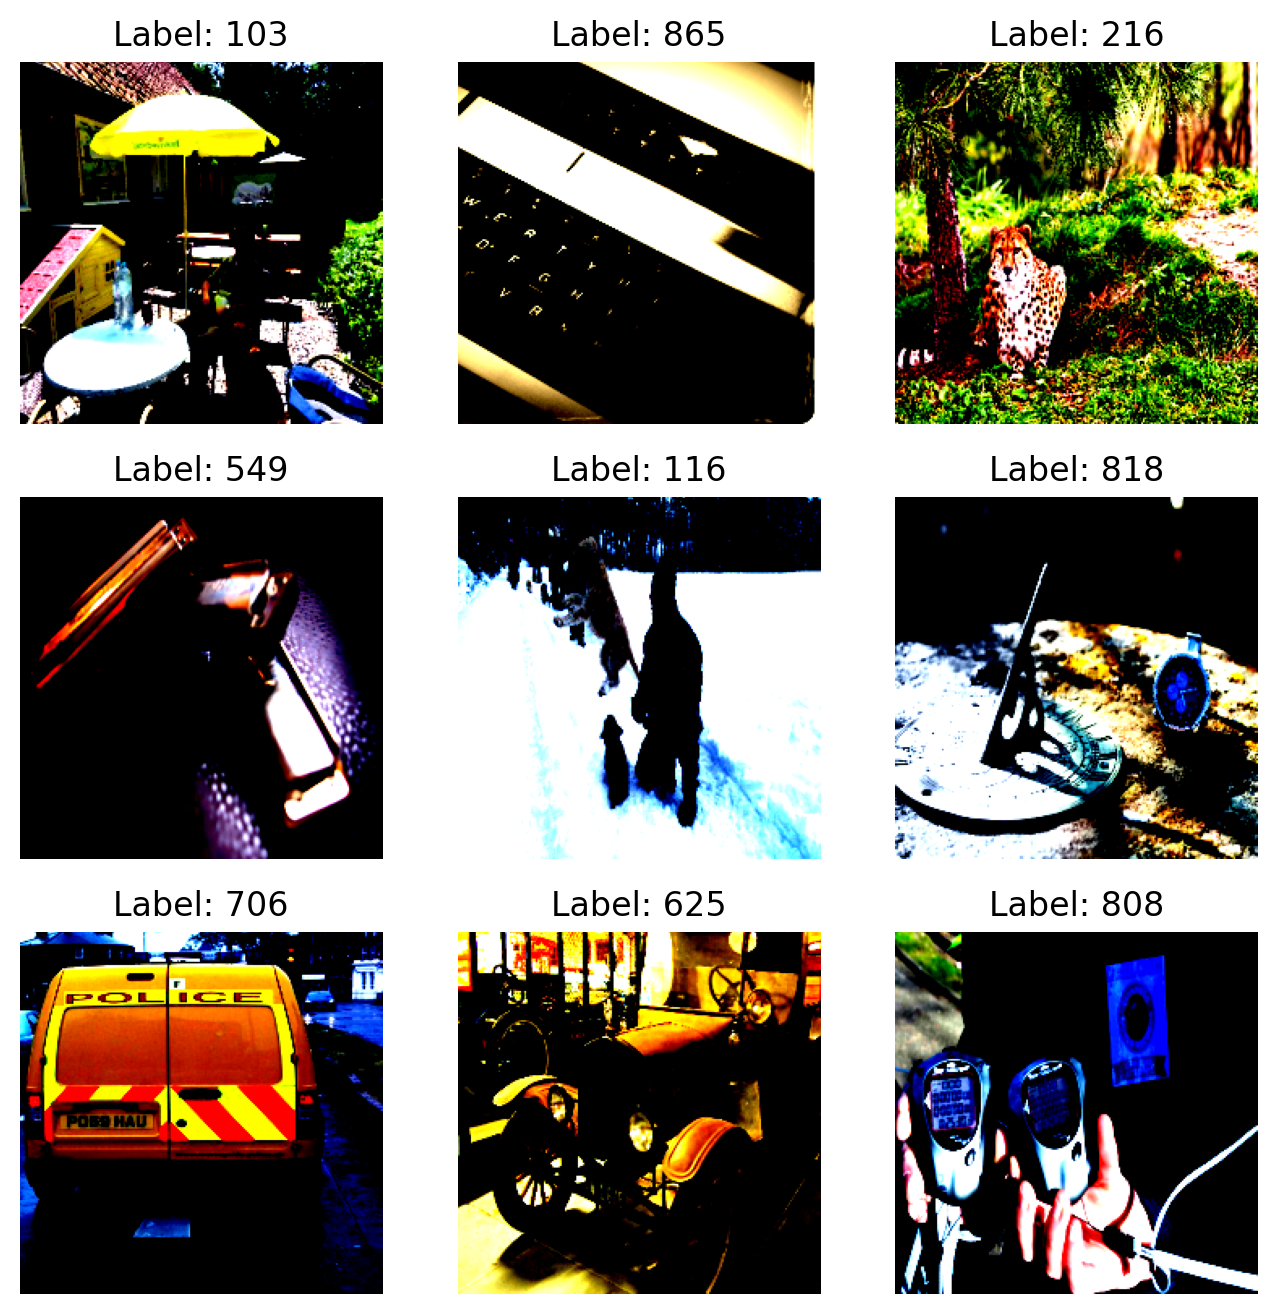

In [10]:
# show some imagenet-v2 images (no labelmap, because we have 1000 labels 😐)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Iterate over batches loaded from the DataLoader
for batch_idx, (data, labels) in enumerate(train_loader_imagenetv2, 1):
    # Iterate over data within the batch
    for img_idx, (img, label) in enumerate(zip(data, labels), 1):
        # Add subplot to the figure
        subplot_idx = (batch_idx - 1) * len(data) + img_idx
        if subplot_idx > cols * rows:
            break

        figure.add_subplot(rows, cols, subplot_idx)

        # Display the image and the label
        plt.title(f"Label: {label.item()}")  # Display the label as title
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))  # Permute dimensions to fit matplotlib format

    # If enough subplots have been displayed, exit the outer loop
    if batch_idx * len(data) >= cols * rows:
        break

plt.show()

## CLIP


In [11]:
!pip install -q ftfy regex tqdm scikit-learn scikit-image
!pip install -q git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


###Loading the model

In [19]:
from clip import clip

model, preprocess = clip.load("ViT-B/32")
model = model.cuda().eval()

print(preprocess)

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x797c9208ef80>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


### Preparing ImageNet labels and prompts

In [13]:
imagenet_classes = [
    "stingray", "goldfinch", "junco", "American robin", "jay", "bald eagle", "vulture", "newt", "American bullfrog", "box turtle", "green iguana",
    "agama", "chameleon", "American alligator", "garter snake", "harvestman", "scorpion", "tarantula", "centipede", "sulphur-crested cockatoo",
    "lorikeet", "hummingbird", "toucan", "duck", "goose", "koala", "jellyfish", "sea anemone", "flatworm", "snail", "crayfish",
    "hermit crab", "flamingo", "great egret", "oystercatcher", "pelican", "sea lion", "Chihuahua", "Golden Retriever", "Rottweiler",
    "German Shepherd Dog", "pug", "red fox", "Persian cat", "lynx", "lion", "American black bear", "mongoose", "ladybug", "rhinoceros beetle",
    "weevil", "fly", "bee", "ant", "grasshopper", "stick insect", "cockroach", "mantis", "leafhopper", "dragonfly", "monarch butterfly",
    "small white", "gossamer-winged butterfly", "starfish", "cottontail rabbit", "porcupine", "fox squirrel", "marmot", "bison", "skunk", "armadillo",
    "baboon", "white-headed capuchin", "African bush elephant", "pufferfish", "academic gown", "accordion", "acoustic guitar", "airliner", "ambulance",
    "apron", "balance beam", "balloon", "banjo", "barn", "wheelbarrow", "basketball", "lighthouse", "beaker", "bikini", "bow", "bow tie",
    "breastplate", "broom", "candle", "canoe", "castle", "cello", "chain", "chest", "Christmas stocking", "cowboy boot", "cradle", "rotary dial telephone",
    "digital clock", "doormat", "drumstick", "dumbbell", "envelope", "feather boa", "flagpole", "forklift", "fountain", "garbage truck",
    "goblet", "go-kart", "golf cart", "grand piano", "hair dryer", "clothes iron", "jack-o'-lantern", "jeep", "kimono", "lighter",
    "limousine", "manhole cover", "maraca", "marimba", "mask", "mitten", "mosque", "nail", "obelisk", "ocarina", "organ", "parachute",
    "parking meter", "piggy bank", "billiard table", "hockey puck", "quill", "racket", "reel", "revolver", "rocking chair", "rugby ball",
    "salt shaker", "sandal", "saxophone", "school bus", "schooner", "sewing machine", "shovel", "sleeping bag", "snowmobile", "snowplow",
    "soap dispenser", "spatula", "spider web", "steam locomotive", "stethoscope", "couch", "submarine", "sundial", "suspension bridge", "syringe",
    "tank", "teddy bear", "toaster", "torch", "tricycle", "umbrella", "unicycle", "viaduct", "volleyball", "washing machine", "water tower",
    "wine bottle", "shipwreck", "guacamole", "pretzel", "cheeseburger", "hot dog", "broccoli", "cucumber", "bell pepper", "mushroom",
    "lemon", "banana", "custard apple", "pomegranate", "carbonara", "bubble", "cliff", "volcano", "baseball player", "rapeseed",
    "yellow lady's slipper", "corn", "acorn"
]

In [14]:
imagenet_templates = [
    'a bad photo of a {}.',
    'a photo of many {}.',
    'a sculpture of a {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of the {}.',
    'a rendering of a {}.',
    'graffiti of a {}.',
    'a bad photo of the {}.',
    'a cropped photo of the {}.',
    'a tattoo of a {}.',
    'the embroidered {}.',
    'a photo of a hard to see {}.',
    'a bright photo of a {}.',
    'a photo of a clean {}.',
    'a photo of a dirty {}.',
    'a dark photo of the {}.',
    'a drawing of a {}.',
    'a photo of my {}.',
    'the plastic {}.',
    'a photo of the cool {}.',
    'a close-up photo of a {}.',
    'a black and white photo of the {}.',
    'a painting of the {}.',
    'a painting of a {}.',
    'a pixelated photo of the {}.',
    'a sculpture of the {}.',
    'a bright photo of the {}.',
    'a cropped photo of a {}.',
    'a plastic {}.',
    'a photo of the dirty {}.',
    'a jpeg corrupted photo of a {}.',
    'a blurry photo of the {}.',
    'a photo of the {}.',
    'a good photo of the {}.',
    'a rendering of the {}.',
    'a {} in a video game.',
    'a photo of one {}.',
    'a doodle of a {}.',
    'a close-up photo of the {}.',
    'a photo of a {}.',
    'the origami {}.',
    'the {} in a video game.',
    'a sketch of a {}.',
    'a doodle of the {}.',
    'a origami {}.',
    'a low resolution photo of a {}.',
    'the toy {}.',
    'a rendition of the {}.',
    'a photo of the clean {}.',
    'a photo of a large {}.',
    'a rendition of a {}.',
    'a photo of a nice {}.',
    'a photo of a weird {}.',
    'a blurry photo of a {}.',
    'a cartoon {}.',
    'art of a {}.',
    'a sketch of the {}.',
    'a embroidered {}.',
    'a pixelated photo of a {}.',
    'itap of the {}.',
    'a jpeg corrupted photo of the {}.',
    'a good photo of a {}.',
    'a plushie {}.',
    'a photo of the nice {}.',
    'a photo of the small {}.',
    'a photo of the weird {}.',
    'the cartoon {}.',
    'art of the {}.',
    'a drawing of the {}.',
    'a photo of the large {}.',
    'a black and white photo of a {}.',
    'the plushie {}.',
    'a dark photo of a {}.',
    'itap of a {}.',
    'graffiti of the {}.',
    'a toy {}.',
    'itap of my {}.',
    'a photo of a cool {}.',
    'a photo of a small {}.',
    'a tattoo of the {}.',
]

print(f"{len(imagenet_classes)} classes, {len(imagenet_templates)} templates")

200 classes, 80 templates


###Creating zero-shot classifier weights

In [21]:
def zeroshot_classifier(classnames, templates):
    with torch.no_grad():
        zeroshot_weights = []
        for classname in tqdm(classnames):
            texts = [template.format(classname) for template in templates] #format with class
            texts = clip.tokenize(texts).cuda() #tokenize
            class_embeddings = model.encode_text(texts) #embed with text encoder
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            zeroshot_weights.append(class_embedding)
        zeroshot_weights = torch.stack(zeroshot_weights, dim=1).cuda()
    return zeroshot_weights


zeroshot_weights = zeroshot_classifier(imagenet_classes, imagenet_templates)

100%|██████████| 200/200 [00:10<00:00, 18.88it/s]


###Zero-shot prediction

In [32]:
def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]


with torch.no_grad():
    top1, top5, n = 0., 0., 0.
    for i, (images, target) in enumerate(tqdm(train_loader_imageneta)):
        images = images.cuda()
        target = target.cuda()

        # predict
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ zeroshot_weights

        # measure accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1 += acc1
        top5 += acc5
        n += images.size(0)

top1 = (top1 / n) * 100
top5 = (top5 / n) * 100

print("\n---------------------------")
print(f"Top-1 accuracy: {top1:.2f}")
print(f"Top-5 accuracy: {top5:.2f}")

  0%|          | 0/47 [00:00<?, ?it/s]<ipython-input-32-fae415cbcb1e>:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]
100%|██████████| 47/47 [00:36<00:00,  1.30it/s]


---------------------------
Top-1 accuracy: 17.80
Top-5 accuracy: 41.76
